# Random Variable Generator

Lets consider a density function $f$. We want to create $$X : \mathcal{B}(\mathbb{R}) \longrightarrow [b_{inf}, b_{sup}]$$ such as $$f(x) = p_X(x)$$ Or in other words :


$$\mathbb {P} (a\leqslant X\leqslant b)=\int _{a}^{b}f(t)\,\mathrm {d} t$$

In order to create this random variable, the method taken is based on the following result :

> *For every $a, b \in [b_{inf}, b_{sup}]$ with $a\leqslant b$, it exists a single barycenter value $x_{bary}$ such as $$\mathbb {P} (a\leqslant X\leqslant x_{bary}) = \mathbb {P} (x_{bary}\leqslant X\leqslant b)$$ and it value is given by: $$\int_{a}^{x_{bary}} f(t) dt = \int_{x_{bary}}^{b} f(t) dt$$*

The idea is to create a binary tree where each node is the barycenter of its interval. To sample a number, we just have to fall a ball in the tree where at each node the child node taken is chosen by a equiprobable bernoulli law (flip a coin).

The class RandomVariableGenerator allows the user to create a random variable where he can sample it from any function.
The user gives the function and the bounds of the function. The code will normalize it to make this function a density function, the you can create the milestone list. The more the milestone list is big, the more precise will be the sampled number. The milestone list contains all the information to create the binary tree. So the method ```create_binary_tree``` creates the binary tree from the milestone list.

For instance, if you create a binary tre of depth 2, the milestone list will have the length 2^2 + 1 = 5 so you sampled number can take only 5 numbers. But if you do that with a tree of depth 1, you will get a milestone list of length 2^16 + 1 = 65537. So your sample can take 65537 different values, which is a way better.

## Code

In [43]:
import numpy as np

import matplotlib.pylab as plt
import scipy.integrate
import time
from tqdm import tqdm
import multiprocessing

In [44]:
class RandomVariableGenerator:
    """
    Creates the random variable from it density function

    ...

    Attributes
    ----------
    f : function
        Initial function (normalized in the constructor)
    b_inf : float
        Minimal bound of the function
    b_sup : float
        Maximal bound of the function
    list_milestones : list
        List of milestones computed in create_milestones
    vertical_bounds : list
        Vertical bounds of the function
    """
    def __init__(self, f: callable, b_inf:float=-1, b_sup:float = 1):
        """
        Creates the random variable from it density function

        Parameters
        ----------
        f : callable
            Initial function
        b_inf : float
            Minimal bound of the function
        b_sup : float
            Maximal bound of the function
        """
        self.b_inf = b_inf
        self.b_sup = b_sup
        self.list_milestones = []
        integral_f = scipy.integrate.quad(f,b_inf,b_sup)[0]
        self.f = lambda x:f(x)/integral_f
    
    def plot_function(self):
        """
        Plot the function
        """
        x_values = np.linspace(b_inf, b_sup, 1000)
        y_values = self.f(x_values)
        plt.plot(x_values, y_values, label='f(x) normalized')
        plt.title('Function')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.legend()
        self.vertical_bounds = plt.ylim()
    
    def add_vertical_line(self, x, depth:float=0):
        """
        Add a vertical line on the plot

        Parameters
        ----------
        x : float
            The x-abciss of the line
        depth : float, optionnal
            Importance of the line influences the length of it
        """
        assert self.vertical_bounds != None, "Please plot the function before plotting vertical lines."
        plt.vlines(x=x, ymin=self.vertical_bounds[0], ymax=self.get_y(depth), color='r', linestyle='--', lw=self.get_lw(depth))
    
    def get_y(self,depth):
        return 3/4*(self.vertical_bounds[1] - self.vertical_bounds[0])*(2**(-depth) +1)
    
    def get_lw(self, depth):
        return 2**(1-depth/2)
    
    def get_barycenter(self, inf, sup, prec = None):
        """
        Find the x-barycenter of the function in the given bounds. Uses Newton's method.

        Parameters
        ----------
        inf : float
            Minimal bound
        sup : float 
            Maximal bound
        prec : int, optionnal
            Precision of the result. Prec defines the number of iterations for the method

        Returns
        -------
        value, error : tuple
            The value and it error on precision
        """
        F = lambda x: scipy.integrate.quad(self.f,inf,x)[0] - scipy.integrate.quad(self.f,x,sup)[0]
        prec = prec if prec != None else 4
        point = (inf+sup)/2
        for _ in range(prec):
            point = point - F(point)/(2*self.f(point))
        return point, F(point)
    
    def create_milestones(self, depth:int = 5, plot:bool = False):
        """
        Creates the milestone list calling recusively the method get_barycenter

        Parameters
        ----------
        depth : int, optionnal
            Depth of the tree
        plot : bool, optionnal
            Plot the barycenters at each iteration when True
        
        """
        max_depth = depth
        b_inf, b_sup = self.b_inf, self.b_sup
        list_milestones = np.array([b_inf, b_sup])
        with tqdm(total=2**depth-1, dynamic_ncols=True) as pbar:
            for depth in range(max_depth):
                slicings = self.get_slicings(list_milestones)
                new_slicings = np.zeros(len(slicings))
                for index, item in enumerate(slicings):
                    inf, sup = item[0], item[1]
                    new_slicing = self.get_barycenter(inf, sup)[0]
                    new_slicings[index] = new_slicing
                    if plot:
                        self.add_vertical_line(new_slicing,depth=depth)
                    pbar.update(1)
                list_milestones = np.sort(np.concatenate([list_milestones,new_slicings]))
        self.list_milestones = list_milestones

    @staticmethod
    def get_slicings(list_):
        """
        Get the slicings of a list

        Parameters
        ----------
        list_ : list
            Input list
        """
        return [[list_[i], list_[i+1]] for i in range(len(list_)-1)]
    
    def get_sample(self, make_continuous=True):
        """
        Get a sample of the random variable

        Returns
        -------
        sample : float
            The new sample
        """
        assert len(self.list_milestones) != 0, "Cannot create a sample because no tree was built (no milestone list)"
        length_list = len(self.list_milestones)
        right = length_list
        left = 0
        continue_loop = True
        while continue_loop:
            choice = np.random.randint(0,2)
            if choice:
                left = (right+left)//2
            else :
                right = (right+left)//2
            if left == right:
                continue_loop = False
        min_value = self.list_milestones[left-1] if left != 0 else self.list_milestones[left]
        max_value = self.list_milestones[right+1] if right + 1 != length_list else self.list_milestones[right]
        return np.random.uniform(min_value, max_value)
    
    def plot_tree(self):
        """
        Calculate the corresponding tree from the milestone list and plot it.
        """
        list_milestones = self.list_milestones
        length_list = len(self.list_milestones)
        left = 0
        right = length_list -1 
        root = (left+right)//2
        queue = [[root, left, right, None, 0]]
        while len(queue) != 0:
            node, left, right, father, depth = queue.pop(0)
            if father != None:
                plt.plot([list_milestones[node], list_milestones[father]],[self.get_y(depth), self.get_y(depth-1)],marker='', linestyle='-', color = 'black')
            if node != left + 1 and node != right - 1:
                queue.append([(left+node)//2, left, node, node, depth+1])
                queue.append([(right+node)//2, node, right, node, depth+1])
        return


## Testing the algorithm

In this part, I test the algorithm with small example to show how it works.

x-Barycenter of the function: -0.24


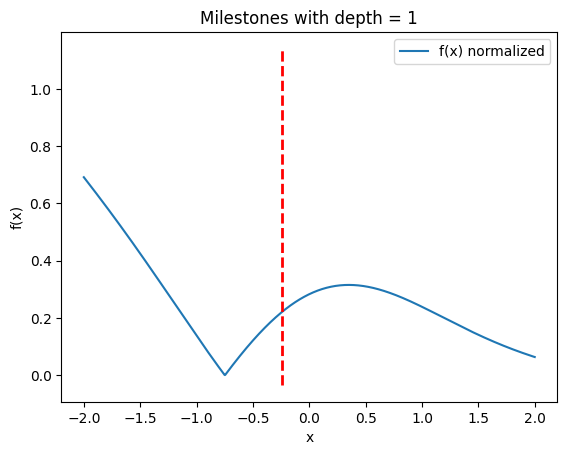

100%|██████████| 3/3 [00:00<00:00, 290.10it/s]


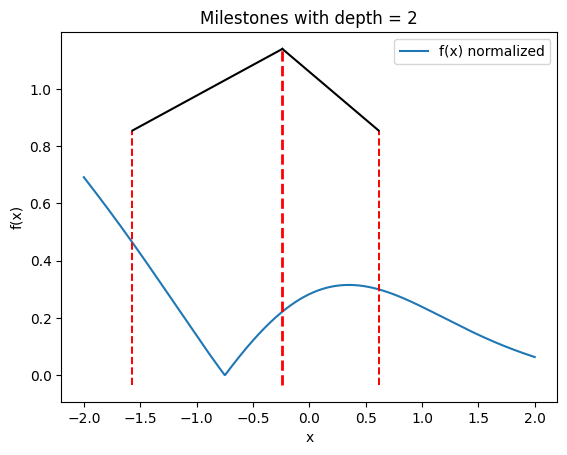

100%|██████████| 7/7 [00:00<00:00, 791.48it/s]


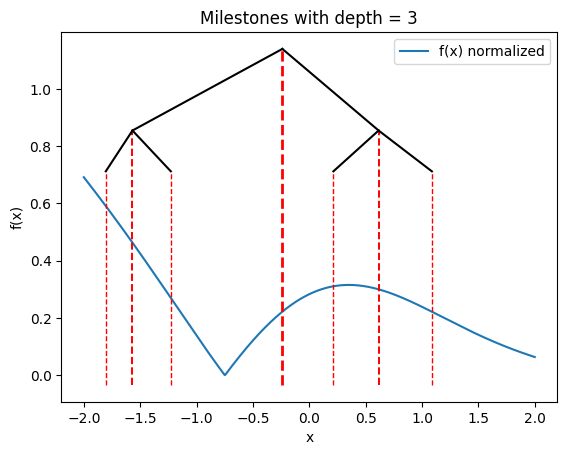

100%|██████████| 31/31 [00:00<00:00, 1241.18it/s]


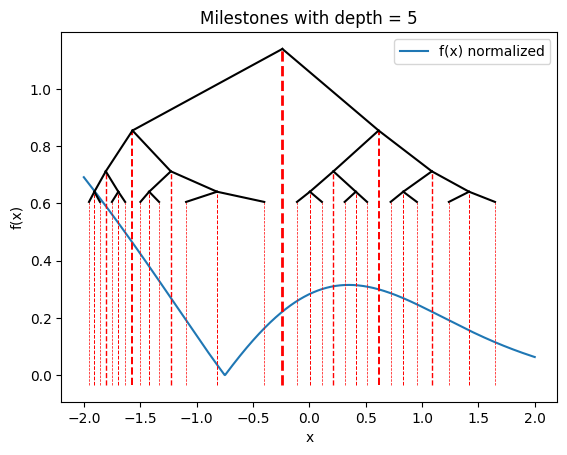

In [45]:
f = lambda x : abs(-np.exp(-x**2/2) + 0.1*(x-2)**2) #initial function (unnormalized)
b_inf, b_sup = -2, 2 #bounds of the function
rvg = RandomVariableGenerator(f,b_inf,b_sup)

barycenter, error = rvg.get_barycenter(b_inf,b_sup)
print('x-Barycenter of the function:', np.round(barycenter,2))
rvg.plot_function()
plt.title('Milestones with depth = 1')
rvg.add_vertical_line(barycenter)
plt.show()

depth=2
rvg.plot_function()
rvg.create_milestones(depth=depth, plot=True)
rvg.plot_tree()
plt.title('Milestones with depth = '+ str(depth))
plt.show()

depth=3
rvg.plot_function()
rvg.create_milestones(depth=depth, plot=True)
rvg.plot_tree()
plt.title('Milestones with depth = '+ str(depth))
plt.show()

depth=5
rvg.plot_function()
rvg.create_milestones(depth=depth, plot=True)
plt.title('Milestones with depth = '+ str(depth))
rvg.plot_tree()
plt.show()

In the following code, I test my new random variable by getting samples and plotting the histogram. You see that the histogram isn't perfect with depth=5

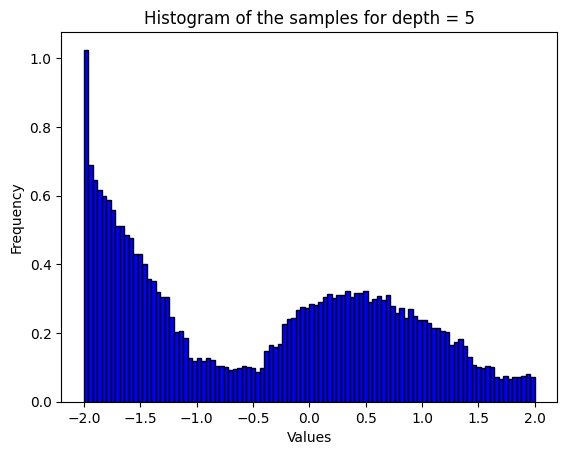

In [46]:
plt.hist([rvg.get_sample() for _ in range(int(1e5))], bins=100, color='blue', edgecolor='black', density=True)

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of the samples for depth = {depth}')

plt.show()

Now I create a tree with high depth (17) in order to make a random variable very precise.

In [47]:
depth = 17
print('Building the milesone list with depth =', depth)
rvg.create_milestones(depth=depth,plot=False)
print('Length of the milestone list:', len(rvg.list_milestones))

Building the milesone list with depth = 17


100%|██████████| 131071/131071 [00:21<00:00, 6074.82it/s]

Length of the milestone list: 131073


I test my random variable.

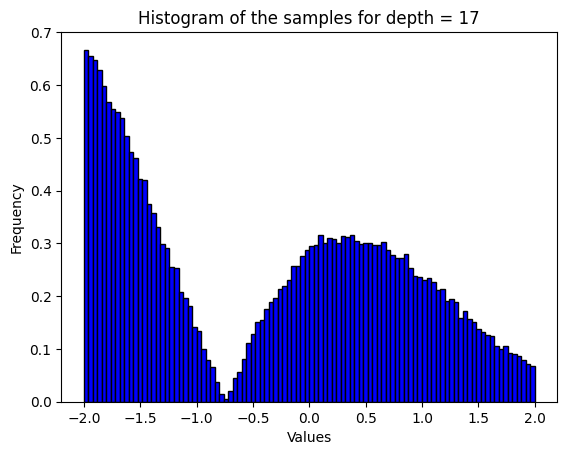

In [48]:
plt.hist([rvg.get_sample() for _ in range(int(1e5))], bins=100, color='blue', edgecolor='black', density=True)

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of the samples for depth = {depth}')

plt.show()

Gif of the histograms for tree with depth between 1 and 17.

![histogram-gif.gif](histogram-gif.gif)

A gif more precise.

![histogram-precise-gif.gif](histogram-precise-gif.gif)

100%|██████████| 1023/1023 [00:00<00:00, 2507.17it/s]


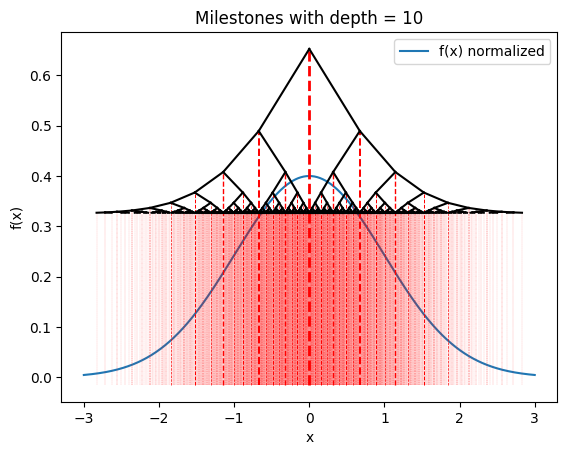

In [49]:
f = lambda x: np.exp(-x**2/2)
b_inf, b_sup = -3, 3 #bounds of the function
rvg = RandomVariableGenerator(f,b_inf,b_sup)
depth=10
rvg.plot_function()
rvg.create_milestones(depth=depth, plot=True)
plt.title('Milestones with depth = '+ str(depth))
rvg.plot_tree()
plt.show()